In [1]:
import datetime

import pandas as pd
pd.option_context('display.max_columns', None)
import numpy as np

!pip install yfinance -q
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from catboost import CatBoostRegressor, Pool

from torch import nn, from_numpy, zeros
from torch.nn.functional import relu
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
import shutil

import warnings
warnings.filterwarnings('ignore')

2024-06-17 18:12:41.825291: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 18:12:41.825445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 18:12:41.978186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_18/1944192295.py:29: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


## Collecting data & engineering features

For our pipeline of data transformation we should generate more meaningful features from time series data, filter and scale them to make more accurate predictions

In [2]:
def scale(df):
    scalers = {}
    for column in df.columns:
        scaler = StandardScaler()
        scaler.fit(df[column].values.reshape(-1, 1))
        scalers[column] = scaler
        df[column] = scaler.transform(df[column].values.reshape(-1, 1))
    return scalers

In [3]:
def unscale(df, scalers):
    df = df.copy()
    for column in df.columns:
        df[column] = scalers[column].inverse_transform(df[column].values.reshape(-1, 1))
        
    return df

In [4]:
def drop_outliers_3_sigma(df):

    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()

        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std

        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [5]:
def to_float32(df):
    for column in df.columns:
        df[column] = np.clip(df[column], np.finfo(np.float32).min, np.finfo(np.float32).max)
        df[column] = df[column].astype(np.float32)

In [6]:
def generate_features(df):
    df['Range'] = df['High'] - df['Low']
    df['Body'] = df['Close'] - df['Open']
    df['Dip'] = df['Close'] - df['Low']
    window_size = 50
    rolling_mean = df['Close'].rolling(window_size).mean()
    df['MA'] = rolling_mean
    df['MA Norm Close'] = df['Close'] / rolling_mean
    df['Relative Close'] = df['Close'].pct_change()
    df['Relative Volume'] = df['Volume'].pct_change()
    df['Relative Range'] = df['Range'].pct_change()
    df['Relative Body'] = df['Body'].pct_change()
    df['Relative Dip'] = df['Dip'].pct_change()

In [7]:
def get_pretrain_df(tickers, start_day, end_day):
    df_tickers = {}
    scalers_tickers = {}
    
    for ticker in tickers:
        df = yf.Ticker(ticker).history(start=start_day, end=end_day, interval='1d')
        df.bfill(inplace=True)
        generate_features(df)
        df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
        df.dropna(inplace=True)
        df.drop(['Dividends', 'Stock Splits', 'High', 'Low', 'Open'], axis=1, inplace=True)
        drop_outliers_3_sigma(df)
        to_float32(df)
        scalers = scale(df)
        df_tickers[ticker] = df
        scalers_tickers[ticker] = scalers
    
    return df_tickers, scalers_tickers

In [8]:
tickers = ['BTC-USD', '%5EGSPC', 'XMR-USD', 'ETH-USD']
start_day = '2018-01-01'
today = datetime.datetime.today().strftime('%Y-%m-%d')

df_tickers, scalers_tickers = get_pretrain_df(tickers, start_day, today)

unscaling example

In [9]:
'''print('orig')
orig = yf.Ticker(tickers[0]).history(start=start_day, end=today, interval='1d')
display(orig.head(3))

for column in orig.columns:
    plt.plot(orig[column])
plt.show()

print('unscaled')
copy = df_tickers[tickers[0]].copy(deep=True)
copy = unscale(copy, scalers_tickers[tickers[0]])
display(copy.head(3))

for column in copy.columns:
    plt.plot(copy[column])
plt.show()

print('scaled')
display(df_tickers[tickers[0]].head(3))

for column in df_tickers[tickers[0]].columns:
    plt.plot(df_tickers[tickers[0]][column])
plt.show()'''

"print('orig')\norig = yf.Ticker(tickers[0]).history(start=start_day, end=today, interval='1d')\ndisplay(orig.head(3))\n\nfor column in orig.columns:\n    plt.plot(orig[column])\nplt.show()\n\nprint('unscaled')\ncopy = df_tickers[tickers[0]].copy(deep=True)\ncopy = unscale(copy, scalers_tickers[tickers[0]])\ndisplay(copy.head(3))\n\nfor column in copy.columns:\n    plt.plot(copy[column])\nplt.show()\n\nprint('scaled')\ndisplay(df_tickers[tickers[0]].head(3))\n\nfor column in df_tickers[tickers[0]].columns:\n    plt.plot(df_tickers[tickers[0]][column])\nplt.show()"

## Visualisation

,Close,Volume,Range,Body,Dip,MA,MA Norm Close,Relative Close,Relative Volume,Relative Range,Relative Body,Relative Dip
Date,,,,,,,,,,,,
2018-02-19 00:00:00+00:00,-0.728370,-1.052946,-0.280804,0.622706,0.116027,-0.706085,-0.356512,1.801842,-0.535013,-0.474740,-0.023539,-0.025702
2018-02-20 00:00:00+00:00,-0.718737,-0.921005,-0.306307,0.141646,-0.484579,-0.708622,-0.231277,0.415854,0.873520,-0.285806,-0.004092,-0.042973
2018-02-21 00:00:00+00:00,-0.757255,-0.951240,-0.146287,-0.678404,-0.440773,-0.713455,-0.588009,-1.852214,-0.293520,0.014037,-0.061409,-0.037114


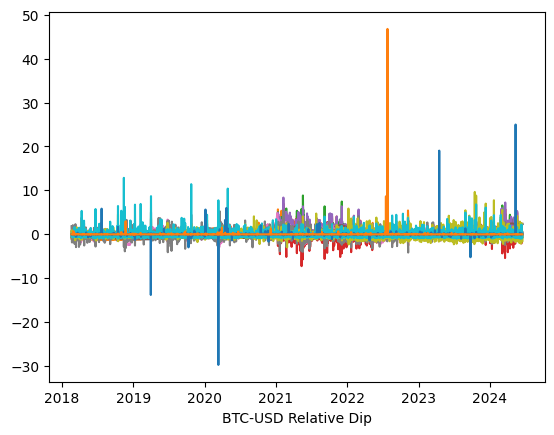

,Close,Volume,Range,Body,Dip,MA,MA Norm Close,Relative Close,Relative Volume,Relative Range,Relative Body,Relative Dip
Date,,,,,,,,,,,,
2018-03-14 00:00:00-04:00,-1.274625,-0.773962,-0.398872,-0.742002,-0.794575,-1.266587,-0.229816,-0.489945,0.035964,-0.596152,0.028746,-0.080501
2018-03-15 00:00:00-04:00,-1.277435,-0.628631,-0.778699,-0.220897,-0.761918,-1.265196,-0.257026,-0.099575,0.162423,-0.748881,0.014629,-0.076410
2018-03-16 00:00:00-04:00,-1.271317,1.209389,-1.107853,0.026652,-0.926060,-1.264144,-0.223666,0.096722,2.874945,-0.915742,0.003619,-0.085038


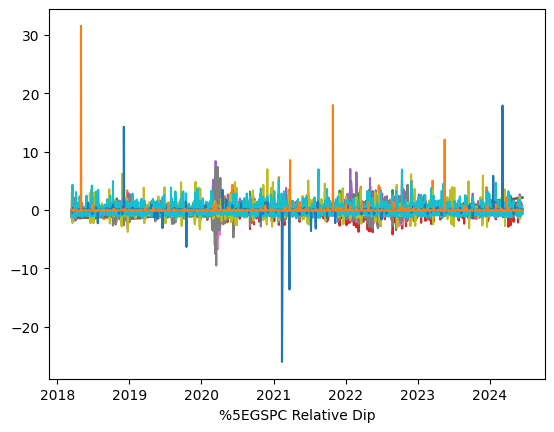

In [10]:
for ticker in tickers[:2]:
    display(df_tickers[ticker].head(3))
    
    for column in df_tickers[ticker].columns:
        plt.plot(df_tickers[ticker][column])
        plt.xlabel(ticker+' '+column)
    plt.show()

In [11]:
'''
for column in df_tickers[tickers[0]].columns:
    sns.displot(df_tickers[tickers[0]], x=column, bins=30)
'''

'\nfor column in df_tickers[tickers[0]].columns:\n    sns.displot(df_tickers[tickers[0]], x=column, bins=30)\n'

There's not a lot of correlation between our features, that's nice

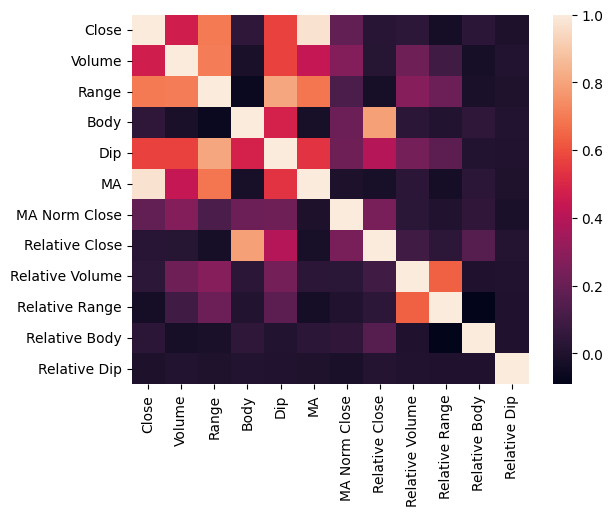

In [12]:
dataplot = sns.heatmap(df_tickers[tickers[0]].corr()) 
plt.show() 

## Train, val, test

In [13]:
btc_x_test = []
btc_y_test = []

In [14]:
predict_window = 50
train_size = 0.8
val_size = 0.15
test_size = 0.05

X_train, Y_train, X_val, Y_val, X_test, Y_test = [], [], [], [], [], []

for ticker in tickers:
    x, y = [], []
    
    for i, row in enumerate(df_tickers[ticker].values[predict_window:]):
        x.append(df_tickers[ticker].values[i:i+predict_window])
        y.append(row[0])
    
    print(len(x), len(y))

    X_train += x[:int(len(x)*train_size)]
    Y_train += y[:int(len(x)*train_size)]
    X_val += x[int(len(x)*train_size):int(len(x)*(train_size+val_size))] 
    Y_val += y[int(len(x)*train_size):int(len(x)*(train_size+val_size))]
    X_test += x[int(len(x)*(train_size+val_size)):]
    Y_test += y[int(len(x)*(train_size+val_size)):]
    
    if ticker == tickers[0]:
        btc_x_test += x[int(len(x)*(train_size+val_size)):]
        btc_y_test += y[int(len(x)*(train_size+val_size)):]

2236 2236
1521 1521
2222 2222
2227 2227


In [15]:
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))
print(len(X_test), len(Y_test))

6562 6562
1231 1231
413 413


In [16]:
display(X_train[0][:5])
Y_train[0]

array([[-0.7283702 , -1.0529462 , -0.28080365,  0.62270576,  0.11602728,
        -0.706085  , -0.3565124 ,  1.8018419 , -0.53501266, -0.4747397 ,
        -0.02353892, -0.02570167],
       [-0.7187365 , -0.9210054 , -0.30630705,  0.14164601, -0.48457944,
        -0.70862246, -0.23127717,  0.41585413,  0.87351966, -0.28580588,
        -0.00409161, -0.04297254],
       [-0.7572549 , -0.95124024, -0.14628714, -0.67840374, -0.44077313,
        -0.7134547 , -0.5880088 , -1.8522136 , -0.29351982,  0.01403685,
        -0.06140932, -0.03711449],
       [-0.79426676, -1.030439  , -0.02545653, -0.6530449 , -0.602422  ,
        -0.7193053 , -0.92503196, -1.897428  , -0.6026903 , -0.09418089,
         0.00549   , -0.0425543 ],
       [-0.7782773 , -1.0478755 , -0.28671646,  0.32620174, -0.04580941,
        -0.72527075, -0.6995464 ,  0.8120433 , -0.24306405, -0.52685136,
        -0.01510184,  0.00657118]], dtype=float32)

-0.9654606

## Catboost

In [17]:
train_pool = Pool([n.flatten() for n in X_train], label=Y_train)
eval_pool = Pool([n.flatten() for n in X_val], label=Y_val)
test_pool = Pool([n.flatten() for n in X_test], label=Y_test)

In [18]:
model = CatBoostRegressor(
    loss_function='MAE', 
    iterations=400, 
    learning_rate=0.05, 
    depth=6, 
    od_wait=20,
    od_type='Iter'
)
model.fit(train_pool, eval_set=eval_pool, verbose_eval=30)

0:	learn: 0.7614207	test: 0.8761439	best: 0.8761439 (0)	total: 185ms	remaining: 1m 13s
30:	learn: 0.2237670	test: 0.1805203	best: 0.1805203 (30)	total: 2.75s	remaining: 32.7s
60:	learn: 0.1057945	test: 0.0857170	best: 0.0857170 (60)	total: 5.2s	remaining: 28.9s
90:	learn: 0.0717991	test: 0.0711711	best: 0.0711711 (90)	total: 7.6s	remaining: 25.8s
120:	learn: 0.0607679	test: 0.0663874	best: 0.0663874 (120)	total: 10.4s	remaining: 24s
150:	learn: 0.0563963	test: 0.0624468	best: 0.0624468 (150)	total: 12.9s	remaining: 21.2s
180:	learn: 0.0531227	test: 0.0601858	best: 0.0601858 (180)	total: 15.3s	remaining: 18.5s
210:	learn: 0.0501852	test: 0.0563303	best: 0.0563303 (210)	total: 17.7s	remaining: 15.9s
240:	learn: 0.0482127	test: 0.0547105	best: 0.0547105 (240)	total: 20.1s	remaining: 13.3s
270:	learn: 0.0465466	test: 0.0541780	best: 0.0541583 (267)	total: 22.6s	remaining: 10.7s
300:	learn: 0.0453849	test: 0.0539969	best: 0.0539899 (298)	total: 25s	remaining: 8.21s
330:	learn: 0.0439500	tes

In [19]:
y_pred = model.predict([n.flatten() for n in X_test])

print('MSE:', mean_squared_error(Y_test, y_pred))
print('MAE:', mean_absolute_error(Y_test, y_pred))
print('r2:', r2_score(Y_test, y_pred))
print('variance:', explained_variance_score(Y_test, y_pred))

MSE: 0.028935556595972443
MAE: 0.13106064912151194
r2: 0.968197758293374
variance: 0.9765526966061787


In [20]:
btc_y_pred = model.predict([n.flatten() for n in btc_x_test])

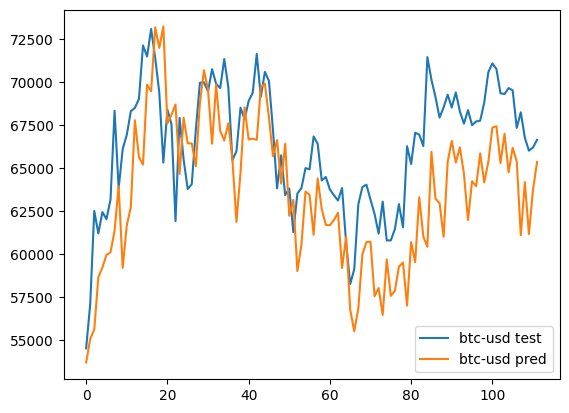

In [21]:
plt.plot(unscale(pd.DataFrame({'Close' : btc_y_test}), scalers_tickers['BTC-USD']), label='btc-usd test')
plt.plot(unscale(pd.DataFrame({'Close' : btc_y_pred}), scalers_tickers['BTC-USD']), label='btc-usd pred')
plt.legend()
plt.show()

Feature importance

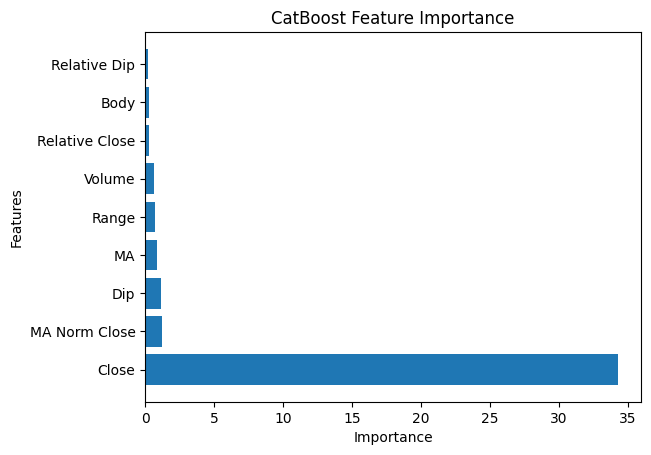

In [22]:
importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=list(df_tickers[tickers[0]].columns)*predict_window).sort_values(ascending=False)
plt.barh(feature_importances.index[:50], feature_importances.values[:50])
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


## ANN

In [23]:
batch_size = 30
n_iters = 10000
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

train = TensorDataset(from_numpy(np.array(X_train)), from_numpy(np.array(Y_train)))
val = TensorDataset(from_numpy(np.array(X_val)), from_numpy(np.array(Y_val)))
test = TensorDataset(from_numpy(np.array(X_test)), from_numpy(np.array(Y_test)))

train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
val_loader = DataLoader(val, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

In [24]:
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.do = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(input_dim, 1000) 
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, 1)
    
    def forward(self, x):
        out = self.fc4(self.do(relu(self.fc3(self.do(relu(self.fc2(self.do(relu(self.fc1(self.do(x)))))))))))
        return out

input_dim = len(df_tickers[tickers[0]].columns) * predict_window
print(input_dim)
model = ANNModel(input_dim)

error = nn.L1Loss()
optimizer = SGD(model.parameters(), lr=2e-3, weight_decay=1e-4)

600


In [25]:
%%time
count = 0

for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(features.view(-1, len(df_tickers[tickers[0]].columns) * predict_window))
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        count += 1
        
        if count % 500 == 0:
            model.eval()
            mae = []
            for features, labels in val_loader:
                y = model(features.view(-1, len(df_tickers[tickers[0]].columns) * predict_window))
                mae.append(mean_absolute_error(labels, y.detach().numpy()))
            
            print('Iteration: {}  Train batch MAE: {}  Test MAE: {}'.format(count, round(loss.item(), 3), round(sum(mae)/len(mae), 3)))
            
        model.train()
    
model.eval()

Iteration: 500  Train batch MAE: 0.117  Test MAE: 0.317
Iteration: 1000  Train batch MAE: 0.136  Test MAE: 0.244
Iteration: 1500  Train batch MAE: 0.106  Test MAE: 0.137
Iteration: 2000  Train batch MAE: 0.068  Test MAE: 0.102
Iteration: 2500  Train batch MAE: 0.224  Test MAE: 0.085
Iteration: 3000  Train batch MAE: 0.112  Test MAE: 0.092
Iteration: 3500  Train batch MAE: 0.148  Test MAE: 0.089
Iteration: 4000  Train batch MAE: 0.18  Test MAE: 0.078
Iteration: 4500  Train batch MAE: 0.114  Test MAE: 0.103
Iteration: 5000  Train batch MAE: 0.097  Test MAE: 0.084
Iteration: 5500  Train batch MAE: 0.117  Test MAE: 0.075
Iteration: 6000  Train batch MAE: 0.102  Test MAE: 0.073
Iteration: 6500  Train batch MAE: 0.334  Test MAE: 0.074
Iteration: 7000  Train batch MAE: 0.201  Test MAE: 0.074
Iteration: 7500  Train batch MAE: 0.071  Test MAE: 0.07
Iteration: 8000  Train batch MAE: 0.131  Test MAE: 0.082
Iteration: 8500  Train batch MAE: 0.057  Test MAE: 0.073
Iteration: 9000  Train batch MAE: 

ANNModel(
  (do): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=600, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=1, bias=True)
)

In [26]:
y_pred = []
for features, labels in test_loader:
    y_pred += model(features.view(-1, len(df_tickers[tickers[0]].columns) * predict_window))
    
y_pred = [n.detach().numpy()[0] for n in y_pred]

In [27]:
print('MSE:', mean_squared_error(Y_test, y_pred))
print('MAE:', mean_absolute_error(Y_test, y_pred))
print('r2:', r2_score(Y_test, y_pred))
print('variance:', explained_variance_score(Y_test, y_pred))

MSE: 0.0329817
MAE: 0.14668754
r2: 0.9637507534874958
variance: 0.9759496450424194


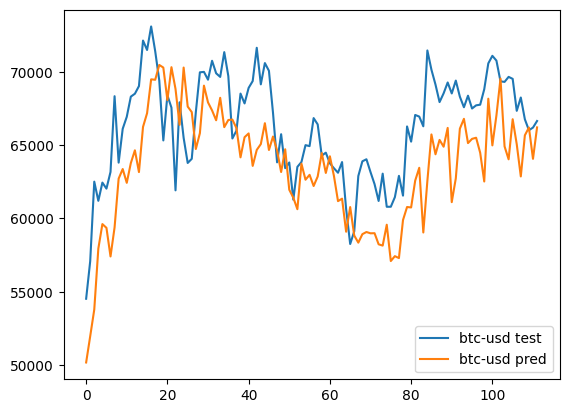

In [28]:
plt.plot(unscale(pd.DataFrame({'Close' : Y_test[:len(btc_y_test)]}), scalers_tickers['BTC-USD']), label='btc-usd test')
plt.plot(unscale(pd.DataFrame({'Close' : y_pred[:len(btc_y_test)]}), scalers_tickers['BTC-USD']), label='btc-usd pred')
plt.legend()
plt.show()

## LSTM

data split

In [29]:
btc = df_tickers[tickers[0]]
btc['target'] = btc["Close"].shift(-1)
btc.drop(btc.tail(1).index, inplace=True)
array = btc.values
display(btc.head(3))
array[:3]

,Close,Volume,Range,Body,Dip,MA,MA Norm Close,Relative Close,Relative Volume,Relative Range,Relative Body,Relative Dip,target
Date,,,,,,,,,,,,,
2018-02-19 00:00:00+00:00,-0.728370,-1.052946,-0.280804,0.622706,0.116027,-0.706085,-0.356512,1.801842,-0.535013,-0.474740,-0.023539,-0.025702,-0.718737
2018-02-20 00:00:00+00:00,-0.718737,-0.921005,-0.306307,0.141646,-0.484579,-0.708622,-0.231277,0.415854,0.873520,-0.285806,-0.004092,-0.042973,-0.757255
2018-02-21 00:00:00+00:00,-0.757255,-0.951240,-0.146287,-0.678404,-0.440773,-0.713455,-0.588009,-1.852214,-0.293520,0.014037,-0.061409,-0.037114,-0.794267


array([[-0.7283702 , -1.0529462 , -0.28080365,  0.62270576,  0.11602728,
        -0.706085  , -0.3565124 ,  1.8018419 , -0.53501266, -0.4747397 ,
        -0.02353892, -0.02570167, -0.7187365 ],
       [-0.7187365 , -0.9210054 , -0.30630705,  0.14164601, -0.48457944,
        -0.70862246, -0.23127717,  0.41585413,  0.87351966, -0.28580588,
        -0.00409161, -0.04297254, -0.7572549 ],
       [-0.7572549 , -0.95124024, -0.14628714, -0.67840374, -0.44077313,
        -0.7134547 , -0.5880088 , -1.8522136 , -0.29351982,  0.01403685,
        -0.06140932, -0.03711449, -0.79426676]], dtype=float32)

In [30]:
X_train = array[:int(len(x)*train_size), :-1]
Y_train = array[:int(len(x)*train_size), -1]
X_val = array[int(len(x)*train_size):int(len(x)*(train_size+val_size)), :-1] 
Y_val = array[int(len(x)*train_size):int(len(x)*(train_size+val_size)), -1]
X_test = array[int(len(x)*(train_size+val_size)):, :-1]
Y_test = array[int(len(x)*(train_size+val_size)):, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [31]:
X_train.shape

(1781, 1, 12)

model train (keras lstm)

In [32]:
model = Sequential()
model.add(LSTM(512, input_shape=(50, 12), return_sequences=True, kernel_regularizer=l2(0.001))) 
model.add(LSTM(512, kernel_regularizer=l2(0.001)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation='relu')) 

model.compile(
    loss='mean_absolute_error', 
    optimizer='adam',
    metrics=[keras.metrics.MeanAbsoluteError()]
)

model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 1.4296 - mean_absolute_error: 0.7341 - val_loss: 0.2132 - val_mean_absolute_error: 0.0831
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.6838 - mean_absolute_error: 0.5804 - val_loss: 0.1186 - val_mean_absolute_error: 0.0625
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.6394 - mean_absolute_error: 0.5905 - val_loss: 0.0870 - val_mean_absolute_error: 0.0516
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5952 - mean_absolute_error: 0.5616 - val_loss: 0.0808 - val_mean_absolute_error: 0.0542
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5892 - mean_absolute_error: 0.5637 - val_loss: 0.0663 - val_mean_absolute_error: 0.0431
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.5806 - mean_absolute_error: 0.5586 - val_loss: 0.0745 - val_mean_absolute_error: 0.0534
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.5832 - mean_absolute_error: 0.5633 - val_loss

In [33]:
# Evaluate the model
loss = model.evaluate(X_test, Y_test)
print('Loss:', loss)

# Make predictions
y_pred = model.predict(X_test)
y_pred = [n[0] for n in y_pred]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1710 - mean_absolute_error: 0.1585 
Loss: [0.20262078940868378, 0.1900574117898941]
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


In [34]:
print('MSE:', mean_squared_error(Y_test, y_pred))
print('MAE:', mean_absolute_error(Y_test, y_pred))
print('r2:', r2_score(Y_test, y_pred))
print('variance:', explained_variance_score(Y_test, y_pred))

MSE: 0.049942836
MAE: 0.19005741
r2: 0.8486925788323916
variance: 0.9483987092971802


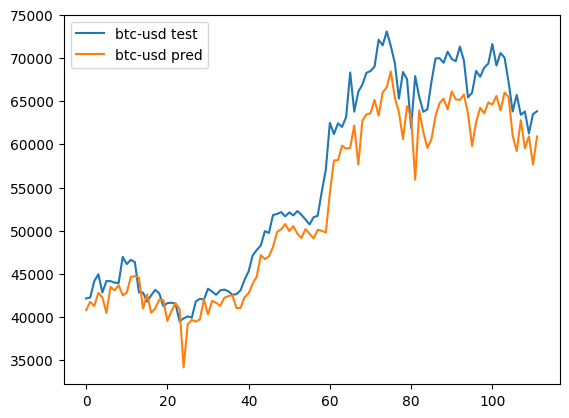

In [35]:
plt.plot(unscale(pd.DataFrame({'Close' : Y_test[:len(btc_y_test)]}), scalers_tickers['BTC-USD']), label='btc-usd test')
plt.plot(unscale(pd.DataFrame({'Close' : y_pred[:len(btc_y_test)]}), scalers_tickers['BTC-USD']), label='btc-usd pred')
plt.legend()
plt.show()